![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/11.Text_Similarities_and_dimension_reduction_visualizations_for_Embeddings.ipynb)






# Similarity Metrics and Dimension Reduction for Textual Embeddings

Most Textual Embeddings map data into a higher dimension space to encode meaning and understanding of the data via pretraining on natural understanding tasks like masking. The resulting vectors usually yield a boost in peformance for most ML algorithms, if given as additional feature to the text. 


Many ML Algorithms use some kind of distance metric to derive their weights and perform inference. We can visualize distances and similarities to get a better understanding of how the ML algorithms will percieve the data and also use this for various downstream tasks like document and question answering systems.

## Colab Setup

In [ ]:
! pip install -q pyspark==3.3.0 spark-nlp==4.2.4
# ! pip install -q plotly  --upgrade

In [ ]:
import sparknlp

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.3.0


### Load Dataset

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_train.csv

In [ ]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("news_category_train.csv").limit(1000)
trainDataset.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                       description|
+--------+--------------------------------------------------+
|Business| Short sellers, Wall Street's dwindling band of...|
|Business| Private investment firm Carlyle Group, which h...|
|Business| Soaring crude prices plus worries about the ec...|
|Business| Authorities have halted oil export flows from ...|
|Business| Tearaway world oil prices, toppling records an...|
|Business| Stocks ended slightly higher on Friday but sta...|
|Business| Assets of the nation's retail money market mut...|
|Business| Retail sales bounced back a bit in July, and n...|
|Business|" After earning a PH.D. in Sociology, Danny Baz...|
|Business| Short sellers, Wall Street's dwindling  band o...|
|Business| Soaring crude prices plus worries  about the e...|
|Business| OPEC can do nothing to douse scorching  oil pr...|
|Business| Non OPEC oil exporters should consider  increa...|
|Busines

# Generate Word, Entity, Sentence and Document Embeddings via Spark NLP
The following code will work any [Word/Sentence Embedding](https://nlp.johnsnowlabs.com/models?task=Embeddings)

We will generate WordEmbeddings with Bert and convert them into Sentence Embeddings with the `SentenceEmbeddings` annotator.

Additionally we predict entities with a NER model and get their aggregated vector representation with the`ChunkEmbeddings` Annotator. 

Thus we have a representation for Sentences, Entities and Words as vectors which we can use

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

sentenceDetector = SentenceDetectorDLModel.pretrained() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")

embeddings = BertEmbeddings().pretrained('bert_base_cased') \
      .setInputCols(["document",'token'])\
      .setOutputCol("embeddings")\
      .setCaseSensitive(False)

embeddingsSentence =BertSentenceEmbeddings.pretrained("sent_small_bert_L2_128", "en") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")

# https://nlp.johnsnowlabs.com/2020/09/08/ner_dl_bert_en.html 
ner_model = NerDLModel.pretrained("ner_dl_bert", "en") \
        .setInputCols(["document", "token", "embeddings"]) \
        .setOutputCol("ner")


converter = NerConverter() \
    .setInputCols(["document", "token", "ner"]) \
    .setOutputCol("entities")

# Convert Entity chunks into Word Embeddings
chunkEmbeddings = ChunkEmbeddings() \
    .setInputCols(["entities", "embeddings"]) \
    .setOutputCol("chunk_embeddings") \
    .setPoolingStrategy("AVERAGE")


# Todo classifier for coloring

clf_pipeline = Pipeline(stages=[document_assembler, 
                                tokenizer,
                                sentenceDetector,
                                embeddings,
                                embeddingsSentence,
                                ner_model,
                                converter,
                                chunkEmbeddings])


# Fit and Transform dataset
clf_pipelineModel = clf_pipeline.fit(trainDataset)
preds = clf_pipelineModel.transform(trainDataset)
preds.show()

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
ner_dl_bert download started this may take some time.
Approximate size to download 15.4 MB
[OK!]
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|         description|            document|               token|           sentences|          embeddings| sentence_embeddings|                 ner|            entities|    chunk_embeddings|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

# Visualize Embeddings with Classification results in lower dimensional space

We can use any of the sk-learn [Manifold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) and [Matrix Decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) algorithms to reduce the dimensionality of the embeddings to something we can visualize, like 3-D, 2-D or 1D .

In [ ]:
# First lets select the embeddings and convert to Pandas because all these methods are numpy based
import pyspark.sql.functions as F
df = preds.select(F.explode(F.arrays_zip(preds.token.result, 
                                         preds.embeddings.embeddings)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("embeds")).limit(1000).toPandas().dropna()
df 

,token,embeds
0,Short,"[0.5633978247642517, -0.30953460931777954, 0.5..."
1,sellers,"[0.2767085134983063, 0.434371680021286, 0.1697..."
2,",","[-0.12046953290700912, 0.1648406684398651, -0...."
3,Wall,"[-0.17843547463417053, -0.44273272156715393, 0..."
4,Street's,"[0.36362117528915405, -0.242559015750885, 0.01..."
...,...,...
995,focus,"[-0.01961318776011467, 0.12914666533470154, -0..."
996,has,"[0.06904424726963043, 0.5448330640792847, -0.2..."
997,been,"[-0.6957489252090454, 0.06847883760929108, -1...."
998,on,"[-0.3318386375904083, 0.10206016898155212, -0...."


In [ ]:
# Convert List of Vectors into an actual matrix
import numpy as np 
v = np.stack(df.embeds)
X = v[:100]

## Manifold Learning Algorithms

We can apply most `Manifold Learning Algorithms` straightforward to our X embedding matrix, which could be generated from any model.

The **n_components** parameter is used to set the dimension of our target space, in our case 1, 2 or 3. 

See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold  for all of them

In [ ]:
from sklearn.manifold import *
#LLE Locally Linear Embedding https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding 
X_emb, err  = locally_linear_embedding(n_components=2,n_neighbors =5,X= X)

# Spectral Embeddings https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding 
X_emb = SpectralEmbedding(n_components=2).fit_transform(X)

# Isomap https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap 
X_emb = Isomap(n_components=2).fit_transform(X)

# MDS  Multidimensional scaling. https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS  
X_emb = MDS(n_components=2).fit_transform(X)


## Matrix Decomposition Algorithms

We can apply most `Manifold Decomposition Algorithms` straightforward to our X embedding matrix, which could be generated from any model.

The **n_components** parameter is used to set the dimension of our target space, in our case 1, 2 or 3. 

See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition for all of them

In [ ]:
from sklearn.decomposition import *

# Dictionary Learning https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html#sklearn.decomposition.DictionaryLearning 
X_emb = DictionaryLearning(n_components=3).fit_transform(X)

# Factor Analysis https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis 
X_emb = FactorAnalysis(n_components=7, random_state=0).fit_transform(X)

# Fact ICA https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA 
X_emb = FastICA(n_components=7,random_state=0).fit_transform(X)


# Incremental PCA  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA 
X_emb = IncrementalPCA(n_components=7, batch_size=200).fit_transform(X)

# Kernel PCA  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA
X_emb =  KernelPCA(n_components=7, kernel='linear').fit_transform(X)

# PCA https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
X_emb = PCA(n_components=2).fit_transform(X)

# Sparse PCA https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA 
X_emb = SparsePCA(n_components=2).fit_transform(X)

# TruncatedSVD https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD 
X_emb = TruncatedSVD(n_components=2).fit_transform(X)

## LLE and NMPF only work on positve valued data
# Laten Dirichlet Allocation (LDA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation 
X_emb = LatentDirichletAllocation(n_components=5,random_state=0).fit(np.abs(X))

# NMF https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF
X_emb = NMF(n_components=2, init='random', random_state=0).fit_transform(np.abs(X))


## Visualize Dimension Reduced Textual Embeddings

You can swap the sample PCA method below with any algorithms above.

We can now easily plot the data with any plotting library, by defining the x,y,z coordinates as the corrosponding reduced dimensions

In [ ]:
import plotly.express as px

In [ ]:
# 3d 
X_emb = PCA(n_components=3).fit_transform(X)
x,y,z = X_emb[:,:1].flatten(), X_emb[:,1:2].flatten(), X_emb[:,2:3].flatten()
d = pd.DataFrame({'x':x,'y':y, 'z':z})
fig = px.scatter_3d(d,x='x', y='y', z='z')
fig.show()

In [ ]:
# 2d 
X_emb = PCA(n_components=2).fit_transform(X)
x,y = X_emb[:,:1].flatten(), X_emb[:,1:].flatten()
d = pd.DataFrame({'x':x,'y':y})
fig = px.scatter(d,x='x', y='y')
fig.show()

In [ ]:
import plotly.express as px
# 1 D 
X_emb = PCA(n_components=1).fit_transform(X)
d = pd.DataFrame({'x':X_emb.flatten(),'y':np.zeros(X_emb.shape[0])})
fig = px.scatter(d,x='x', y='y', title = '1-D Plot')
fig.show()

## Scalable Simmilarity Metrics - Compare Text using embeddings with Similarity Matrices 
  

### Scalable Similarity for Words
https://en.wikipedia.org/wiki/Cosine_similarity

We will be computing **Pairwise Cosine Simmilairty** using only the Spark API. This looks cumbersome compared to tjust a couple of numpy lines, but it scales linearly on a Spark cluster.

We will first normalize the data with the [Spark MLlib normalizer](https://spark.apache.org/docs/latest/ml-features#normalizer) and then compute the pairwise dot product using the Spark Linear Algebra API and RDD API. This is equivalent to the L2 norm.

Since we start with normalizingthe beginning, there is no further division needed after the pairwise dotproduct.


The formula we are looking to implement is the following:

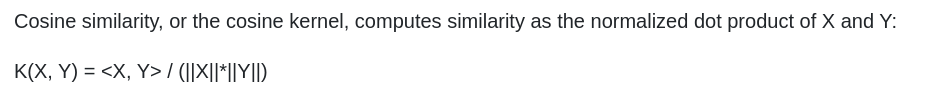


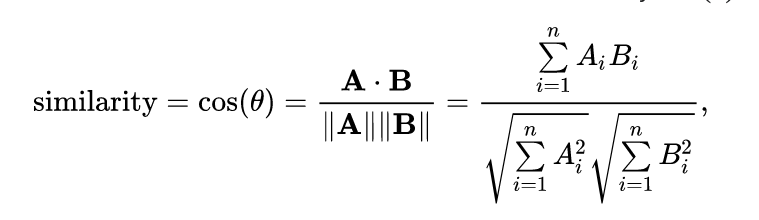



In [ ]:
# Select Tokens, Embeddings and create ID column for each token so we can create Indexed vectors lator on. Spark rows are not orderd by default because distribution is unorderd in cluster.
import pyspark.sql.functions as F
df = preds.select(F.explode(F.arrays_zip(preds.token.result,   
                                         preds.embeddings.embeddings)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("embeds"))\
                  .withColumn("id", F.monotonically_increasing_id()).limit(10)
df.show()

+---------+--------------------+---+
|    token|              embeds| id|
+---------+--------------------+---+
|    Short|[0.5633978, -0.30...|  0|
|  sellers|[0.2767085, 0.434...|  1|
|        ,|[-0.12046953, 0.1...|  2|
|     Wall|[-0.17843547, -0....|  3|
| Street's|[0.36362118, -0.2...|  4|
|dwindling|[0.54948145, -0.2...|  5|
|     band|[0.47735187, -0.3...|  6|
|       of|[-0.23388715, -0....|  7|
|    ultra|[0.067469135, -0....|  8|
|   cynics|[0.24067104, 0.39...|  9|
+---------+--------------------+---+



In [ ]:
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, Vectors, DenseVector
from pyspark.sql.types import * 

# Normalizes calculate L2 Norm aka Euclidean Norm by default. We need this so our simmilarities are between 0 and 1 
normalizer = Normalizer(inputCol="vec_emb", outputCol="normed_embeds")

# Type the data as Spark Vectors so we can use normalizer. Apply by making UDF and applying via withColumn method
f = udf(lambda x : Vectors.dense(x),VectorUDT() )
df = df.withColumn('vec_emb',f('embeds') )
df = normalizer.transform(df)
df.show()

+---------+--------------------+---+--------------------+--------------------+
|    token|              embeds| id|             vec_emb|       normed_embeds|
+---------+--------------------+---+--------------------+--------------------+
|    Short|[0.5633978, -0.30...|  0|[0.56339782476425...|[0.03121254455635...|
|  sellers|[0.2767085, 0.434...|  1|[0.27670851349830...|[0.02177865441379...|
|        ,|[-0.12046953, 0.1...|  2|[-0.1204695329070...|[-0.0089186030203...|
|     Wall|[-0.17843547, -0....|  3|[-0.1784354746341...|[-0.0142570832370...|
| Street's|[0.36362118, -0.2...|  4|[0.36362117528915...|[0.02878442953190...|
|dwindling|[0.54948145, -0.2...|  5|[0.54948145151138...|[0.03697391810465...|
|     band|[0.47735187, -0.3...|  6|[0.47735187411308...|[0.03724555108769...|
|       of|[-0.23388715, -0....|  7|[-0.2338871508836...|[-0.0165807099642...|
|    ultra|[0.067469135, -0....|  8|[0.06746913492679...|[0.00540755882795...|
|   cynics|[0.24067104, 0.39...|  9|[0.2406710386276

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix, MatrixEntry, IndexedRowMatrix, IndexedRow,DenseMatrix
from pyspark.ml.linalg import VectorUDT, Vectors
# We use the RDD API and map each row to an IndexedRow from the distributed linalg API
rows = df.select(['normed_embeds','id']).rdd.map(lambda r : IndexedRow(r.id,r.normed_embeds.toArray()))

# Convert to RowMatrix 
mat = IndexedRowMatrix(rows).toBlockMatrix()
#  calculate DotProduct. The result represents the pairwise Cosine Similarity since we already normalized the data.  
sim = mat.multiply(mat.transpose())

# Convert to Numpy for plotting via Plotly
a = sim.toLocalMatrix().toArray()
import plotly.express as px
pdf = df.toPandas()
fig = px.imshow(a,x=pdf.token.values, y = pdf.token.values, title = 'Similarity Matrix calculated via spark engine - WORDWISE ')
fig.show()

In [ ]:
# Validate results via non distributed Sklearn similarity
from sklearn.metrics.pairwise import cosine_similarity
X = np.stack(pdf.embeds.values)
sk_sim = cosine_similarity(X,X)
fig = px.imshow(sk_sim,x=pdf.token.values, y = pdf.token.values, title = 'Cosine Similarity Matrix calculated via numpy engine and sklearn - WORDWISE ')
fig.show()

### Scalable Similarity for Documents

In [ ]:
# Select Tokens, Embeddings and create ID column for each token so we can create Indexed vectors lator on. Spark rows are not orderd by default because distribution is unorderd in cluster.
import pyspark.sql.functions as F
df = preds.select(F.explode(F.arrays_zip(preds.document.result,   
                                         preds.sentence_embeddings.embeddings)).alias("cols")) \
          .select(F.expr("cols['0']").alias("document"),
                  F.expr("cols['1']").alias("embeds"))\
                  .withColumn("id", F.monotonically_increasing_id()).limit(10)
df.show()

+--------------------+--------------------+---+
|            document|              embeds| id|
+--------------------+--------------------+---+
| Short sellers, W...|[-0.08611238, 0.0...|  0|
| Private investme...|[-0.81050664, 0.9...|  1|
| Soaring crude pr...|[-0.6290261, 0.40...|  2|
| Authorities have...|[-0.23920919, 0.7...|  3|
| Tearaway world o...|[-0.8830513, 0.11...|  4|
| Stocks ended sli...|[-0.39850095, 0.5...|  5|
| Assets of the na...|[-0.7496302, 0.67...|  6|
| Retail sales bou...|[-0.87046015, 0.7...|  7|
|" After earning a...|[-1.1440673, 1.23...|  8|
| Short sellers, W...|[-0.1351473, -3.3...|  9|
+--------------------+--------------------+---+



In [ ]:
# Calculate L2 Norm
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, Vectors, DenseVector
from pyspark.sql.types import * 

# Normalizes calculate L2 Norm aka Euclidean Norm by default. We need this so our simmilarities are between 0 and 1 
normalizer = Normalizer(inputCol="vec_emb", outputCol="normed_embeds")

# Type the data as Spark Vectors so we can use normalizer. Apply by making UDF and applying via withColumn method
f = udf(lambda x : Vectors.dense(x),VectorUDT() )
df = df.withColumn('vec_emb',f('embeds') )
df = normalizer.transform(df)
df.show()

+--------------------+--------------------+---+--------------------+--------------------+
|            document|              embeds| id|             vec_emb|       normed_embeds|
+--------------------+--------------------+---+--------------------+--------------------+
| Short sellers, W...|[-0.08611238, 0.0...|  0|[-0.0861123800277...|[-0.0086857153991...|
| Private investme...|[-0.81050664, 0.9...|  1|[-0.8105066418647...|[-0.0839419161819...|
| Soaring crude pr...|[-0.6290261, 0.40...|  2|[-0.6290261149406...|[-0.0625397481976...|
| Authorities have...|[-0.23920919, 0.7...|  3|[-0.2392091900110...|[-0.0231614869990...|
| Tearaway world o...|[-0.8830513, 0.11...|  4|[-0.8830512762069...|[-0.0908918782656...|
| Stocks ended sli...|[-0.39850095, 0.5...|  5|[-0.3985009491443...|[-0.0423943839461...|
| Assets of the na...|[-0.7496302, 0.67...|  6|[-0.7496302127838...|[-0.0770682278996...|
| Retail sales bou...|[-0.87046015, 0.7...|  7|[-0.8704601526260...|[-0.0887538107839...|
|" After e

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix, MatrixEntry, IndexedRowMatrix, IndexedRow,DenseMatrix
from pyspark.ml.linalg import VectorUDT, Vectors
# We use the RDD API and map each row to an IndexedRow from the distributed linalg API
rows = df.select(['normed_embeds','id']).rdd.map(lambda r : IndexedRow(r.id,r.normed_embeds.toArray()))

# Convert to RowMatrix 
mat = IndexedRowMatrix(rows).toBlockMatrix()
#  calculate DotProduct. The result represents the pairwise Cosine Similarity since we already normalized the data.  
sim = mat.multiply(mat.transpose())

# Convert to Numpy for plotting via Plotly
a = sim.toLocalMatrix().toArray()

import plotly.express as px
pdf = df.toPandas()
fig = px.imshow(a,x=pdf.document.values, y = pdf.document.values, title = 'Similarity Matrix calculated via spark engine - Documentwise ')
fig.show()

In [ ]:
# Validate results via non distributed Sklearn similarity
from sklearn.metrics.pairwise import cosine_similarity
X = np.stack(pdf.embeds.values)
sk_sim = cosine_similarity(X,X)
fig = px.imshow(sk_sim,x=pdf.document.values, y = pdf.document.values, title = 'Cosine Similarity Matrix calculated via numpy engine and sklearn - Documentwise ')
fig.show()

### Scalable Similarity for Entities

In [ ]:
# Select Entities, Entitiy Embeddings and create ID column for each token so we can create Indexed vectors lator on. Spark rows are not orderd by default because distribution is unorderd in cluster.
import pyspark.sql.functions as F
df = preds.select(F.explode(F.arrays_zip(preds.entities.result,   preds.chunk_embeddings.embeddings)).alias("cols")) \
          .select(F.expr("cols['0']").alias("entitiy"),
                  F.expr("cols['1']").alias("embeds"))\
                  .withColumn("id", F.monotonically_increasing_id()).limit(100)
df.show()

+--------------------+--------------------+---+
|             entitiy|              embeds| id|
+--------------------+--------------------+---+
|              DELL.O|[-0.31111044, -0....|  0|
|                OPEC|[0.5533471, -0.60...|  1|
|         Yusgiantoro|[-0.18381658, -0....|  2|
|               Saudi|[0.38682315, -0.4...|  3|
|               Gates|[-0.0776521, -0.5...|  4|
|            Autodesk|[0.5068517, -0.55...|  5|
|             Verizon|[0.55557907, -0.6...|  6|
|             America|[0.45406199, -0.4...|  7|
|               Osaka|[0.3840403, -0.13...|  8|
|             Russian|[0.2939127, -0.64...|  9|
| Armadillo Aerospace|[0.30595315, -0.2...| 10|
|               Texas|[0.24703556, -0.2...| 11|
|               India|[0.39102006, -0.8...| 12|
|                 U.S|[0.3380509, -0.26...| 13|
|                 U.N|[0.17694655, -0.0...| 14|
|               Laden|[-0.62609375, -0....| 15|
|&lt;strong&gt;Com...|[0.3563297, -0.42...| 16|
|      Northumberland|[0.18955362, -0.0.

In [ ]:
# Calculate L2 Norm
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, Vectors, DenseVector
from pyspark.sql.types import * 

# Normalizes calculate L2 Norm aka Euclidean Norm by default. We need this so our simmilarities are between 0 and 1 
normalizer = Normalizer(inputCol="vec_emb", outputCol="normed_embeds")

# Type the data as Spark Vectors so we can use normalizer. Apply by making UDF and applying via withColumn method
f = udf(lambda x : Vectors.dense(x),VectorUDT())
df = df.withColumn('vec_emb',f('embeds') )
df = normalizer.transform(df)
df.show()

+--------------------+--------------------+---+--------------------+--------------------+
|             entitiy|              embeds| id|             vec_emb|       normed_embeds|
+--------------------+--------------------+---+--------------------+--------------------+
|              DELL.O|[-0.31111044, -0....|  0|[-0.3111104369163...|[-0.0228984936385...|
|                OPEC|[0.5533471, -0.60...|  1|[0.55334711074829...|[0.02972146290201...|
|         Yusgiantoro|[-0.18381658, -0....|  2|[-0.1838165819644...|[-0.0143067602937...|
|               Saudi|[0.38682315, -0.4...|  3|[0.38682314753532...|[0.02161039873285...|
|               Gates|[-0.0776521, -0.5...|  4|[-0.0776520967483...|[-0.0063366271021...|
|            Autodesk|[0.5068517, -0.55...|  5|[0.50685167312622...|[0.02591330554106...|
|             Verizon|[0.55557907, -0.6...|  6|[0.55557906627655...|[0.03034643929897...|
|             America|[0.45406199, -0.4...|  7|[0.45406198501586...|[0.02452196771779...|
|         

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix, MatrixEntry, IndexedRowMatrix, IndexedRow,DenseMatrix
from pyspark.ml.linalg import VectorUDT, Vectors
# We use the RDD API and map each row to an IndexedRow from the distributed linalg API
rows = df.select(['normed_embeds','id']).rdd.map(lambda r : IndexedRow(r.id,r.normed_embeds.toArray()))

# Convert to RowMatrix 
mat = IndexedRowMatrix(rows).toBlockMatrix()
#  calculate DotProduct. The result represents the pairwise Cosine Similarity since we already normalized the data.  
sim = mat.multiply(mat.transpose())

# Convert to Numpy for plotting via Plotly
a = sim.toLocalMatrix().toArray()
import plotly.express as px
pdf = df.toPandas()
fig = px.imshow(a,x=pdf.entitiy.values, y = pdf.entitiy.values, title = 'Similarity Matrix calculated via spark engine - Documentwise ')
fig.show()

## Find the K most Similar Words/Entities/Sentences/Documents things - Build your own search engine!

You can use any of the above similarity matrices with the code below

In [ ]:
# This is our similarty matrix. Lets convery it to a Pandas DF 
a.shape

(100, 100)

In [ ]:
sim_df = pd.DataFrame(a)
# You need to update these 2 lines accordingly from entity to document/sentence/token for corrosponding embeddings
sim_df.columns = pdf.entitiy.values
sim_df.index = pdf.entitiy.values
sim_df

,DELL.O,OPEC,Yusgiantoro,Saudi,Gates,Autodesk,Verizon,America,Osaka,Russian,...,American,Puerto Rico,Michael Schumacher,Venezuela's,David Newhan,Orioles,American,49ers,Los Angeles,Sudanese
DELL.O,1.000000,0.302460,0.643395,0.309310,0.558134,0.196923,0.289681,0.265331,0.592562,0.560076,...,0.328312,0.637477,0.504453,0.343556,0.500026,0.492796,0.278308,0.478931,0.630741,0.517896
OPEC,0.302460,1.000000,0.281282,0.946208,0.273387,0.947842,0.955533,0.957425,0.305366,0.165204,...,0.944453,0.274084,0.781183,0.934604,0.739100,0.136590,0.947161,0.208306,0.247421,0.271312
Yusgiantoro,0.643395,0.281282,1.000000,0.312093,0.623515,0.191189,0.286402,0.261444,0.640153,0.612929,...,0.347090,0.714813,0.530297,0.363401,0.591232,0.522997,0.292373,0.521906,0.655905,0.563534
Saudi,0.309310,0.946208,0.312093,1.000000,0.321051,0.937650,0.950388,0.958089,0.323791,0.220313,...,0.939964,0.286647,0.812224,0.928281,0.770518,0.150037,0.946674,0.231853,0.263656,0.337110
Gates,0.558134,0.273387,0.623515,0.321051,1.000000,0.211504,0.300516,0.284673,0.591489,0.519595,...,0.347998,0.580331,0.546109,0.347623,0.642515,0.422268,0.294239,0.571096,0.593737,0.516067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orioles,0.492796,0.136590,0.522997,0.150037,0.422268,0.052758,0.133202,0.119210,0.524101,0.532157,...,0.205468,0.663382,0.356003,0.210166,0.380588,1.000000,0.160765,0.444394,0.649833,0.487454
American,0.278308,0.947161,0.292373,0.946674,0.294239,0.949942,0.960729,0.974715,0.315147,0.182617,...,0.977059,0.289827,0.807133,0.938334,0.773435,0.160765,1.000000,0.225426,0.274708,0.291404
49ers,0.478931,0.208306,0.521906,0.231853,0.571096,0.131858,0.207720,0.200163,0.524693,0.491695,...,0.279801,0.560735,0.442896,0.281555,0.509457,0.444394,0.225426,1.000000,0.592467,0.484698
Los Angeles,0.630741,0.247421,0.655905,0.263656,0.593737,0.157830,0.239957,0.226765,0.626761,0.597294,...,0.329732,0.768536,0.503913,0.351836,0.563578,0.649833,0.274708,0.592467,1.000000,0.624127


### Most similar entries for a text that is already embedded and in our dataset

 existing entry in df defined by Index / Iloc


In [ ]:
# Plot the Data - Barchart style
# Find the N most similar # 14 kek, #41 UK, #15 Senator John F 
entity_iloc = 15
top_N = 14
entity_s  = sim_df.iloc[entity_iloc].sort_values(ascending=False).drop_duplicates().iloc[:top_N]
import plotly.express as px
fig = px.bar(entity_s, y=entity_s.values, x=entity_s.index, title = f'The N most similar Entities for Input Entity = {sim_df.index[entity_iloc]}')
fig.show()

In [ ]:
# Pie Chart style
entity_s  = sim_df.iloc[entity_iloc].sort_values(ascending=False).drop_duplicates().iloc[1:top_N]
fig = px.pie(entity_s, values=entity_s.values, names=entity_s.index,  title=f'The N most similar Entities for Input Entity = {sim_df.index[entity_iloc]}')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# More on Similarity with Embeddings
[Medium Article](https://medium.com/spark-nlp/easy-sentence-similarity-with-bert-sentence-embeddings-using-john-snow-labs-nlu-ea078deb6ebf?source=your_stories_page-------------------------------------)

[NLU Notebook](https://github.com/JohnSnowLabs/nlu/blob/master/examples/colab/component_examples/sentence_embeddings/sentence_similarirty_stack_overflow_questions.ipynb)